## Deep Neural Network with Long Short-Term Memory Layer

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import data_processing
import feature_extraction

Read the whole dataset (not the feature dataset)

In [2]:
df = data_processing.read_all_users('Geolife_data')
df = data_processing.calculations(df)

[1/38] processing user User37
[2/38] processing user User30
[3/38] processing user User31
[4/38] processing user User36
[5/38] processing user User38
[6/38] processing user User2
[7/38] processing user User5
[8/38] processing user User4
[9/38] processing user User3
[10/38] processing user User25
[11/38] processing user User22
[12/38] processing user User14
[13/38] processing user User13
[14/38] processing user User12
[15/38] processing user User15
[16/38] processing user User23
[17/38] processing user User24
[18/38] processing user User33
[19/38] processing user User34
[20/38] processing user User35
[21/38] processing user User32
[22/38] processing user User8
[23/38] processing user User6
[24/38] processing user User1
[25/38] processing user User7
[26/38] processing user User9
[27/38] processing user User21
[28/38] processing user User26
[29/38] processing user User19
[30/38] processing user User10
[31/38] processing user User17
[32/38] processing user User28
[33/38] processing user Us

Put into a time-series format

In [3]:
time_series_features = ['speed', 'acceleration', 'bearing', 'distance']

Normalize the time series features

In [4]:
scaler = StandardScaler()
df[time_series_features] = scaler.fit_transform(df[time_series_features])
df

lat         lon    alt  elapsed time   label                time  \
0    39.894178  116.318200 -777.0  39535.621296   train 2008-03-28 14:54:40   
1    39.894505  116.321132 -777.0  39535.621690   train 2008-03-28 14:55:14   
2    39.894953  116.326452 -777.0  39535.622373   train 2008-03-28 14:56:13   
3    39.894600  116.332542 -777.0  39535.623056   train 2008-03-28 14:57:12   
4    39.889622  116.337040 -777.0  39535.623738   train 2008-03-28 14:58:11   
..         ...         ...    ...           ...     ...                 ...   
471  40.029320  116.411975  289.0  39781.103808  subway 2008-11-29 02:29:29   
472  40.029111  116.411963  275.0  39781.103831  subway 2008-11-29 02:29:31   
473  40.028904  116.411962  274.0  39781.103854  subway 2008-11-29 02:29:33   
474  40.028697  116.411961  274.0  39781.103877  subway 2008-11-29 02:29:35   
475  39.967705  116.412042  333.0  39781.113623  subway 2008-11-29 02:43:37   

                trajectory  user  distance     speed  time_diff  acceleration  \
0    01020080328144824.plt    33       NaN       NaN        NaN           NaN   
1    01020080328144824.plt    33  0.050894  0.324923       34.0           NaN   
2    01020080328144824.plt    33  0.099736  0.367588       59.0     -0.005147   
3    01020080328144824.plt    33  0.115179  0.520650       59.0      0.002174   
4    01020080328144824.plt    33  0.151726  0.882880       59.0      0.016045   
..                     ...   ...       ...       ...        ...           ...   
471  17920081129015805.plt    36 -0.004107  0.911505        2.0     -0.023325   
472  17920081129015805.plt    36 -0.004102  0.913034        2.0     -0.004985   
473  17920081129015805.plt    36 -0.004160  0.895891        2.0     -0.041516   
474  17920081129015805.plt    36 -0.004160  0.895891        2.0     -0.007977   
475  17920081129015805.plt    36  1.615513  0.411862      842.0     -0.010226   

      bearing  heading_change         Vrate  
0         NaN             NaN           NaN  
1   -0.877368             NaN           NaN  
2   -0.859450    2.006376e+00  3.934334e-02  
3   -0.764929    1.058396e+01  1.236873e-01  
4   -0.309939    5.094754e+01  2.264335e-01  
..        ...             ...           ...  
471  0.004004    2.068969e-01  4.817827e-03  
472  0.022736    2.097545e+00  9.382246e-04  
473  0.002147    2.305425e+00  1.063023e-02  
474  0.002147    6.431768e-07  1.993490e-11  
475 -0.000266    2.702611e-01  4.288358e-01  

[1937529 rows x 15 columns]

Encode labels

In [5]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df

lat         lon    alt  elapsed time  label                time  \
0    39.894178  116.318200 -777.0  39535.621296      5 2008-03-28 14:54:40   
1    39.894505  116.321132 -777.0  39535.621690      5 2008-03-28 14:55:14   
2    39.894953  116.326452 -777.0  39535.622373      5 2008-03-28 14:56:13   
3    39.894600  116.332542 -777.0  39535.623056      5 2008-03-28 14:57:12   
4    39.889622  116.337040 -777.0  39535.623738      5 2008-03-28 14:58:11   
..         ...         ...    ...           ...    ...                 ...   
471  40.029320  116.411975  289.0  39781.103808      3 2008-11-29 02:29:29   
472  40.029111  116.411963  275.0  39781.103831      3 2008-11-29 02:29:31   
473  40.028904  116.411962  274.0  39781.103854      3 2008-11-29 02:29:33   
474  40.028697  116.411961  274.0  39781.103877      3 2008-11-29 02:29:35   
475  39.967705  116.412042  333.0  39781.113623      3 2008-11-29 02:43:37   

                trajectory  user  distance     speed  time_diff  acceleration  \
0    01020080328144824.plt    33       NaN       NaN        NaN           NaN   
1    01020080328144824.plt    33  0.050894  0.324923       34.0           NaN   
2    01020080328144824.plt    33  0.099736  0.367588       59.0     -0.005147   
3    01020080328144824.plt    33  0.115179  0.520650       59.0      0.002174   
4    01020080328144824.plt    33  0.151726  0.882880       59.0      0.016045   
..                     ...   ...       ...       ...        ...           ...   
471  17920081129015805.plt    36 -0.004107  0.911505        2.0     -0.023325   
472  17920081129015805.plt    36 -0.004102  0.913034        2.0     -0.004985   
473  17920081129015805.plt    36 -0.004160  0.895891        2.0     -0.041516   
474  17920081129015805.plt    36 -0.004160  0.895891        2.0     -0.007977   
475  17920081129015805.plt    36  1.615513  0.411862      842.0     -0.010226   

      bearing  heading_change         Vrate  
0         NaN             NaN           NaN  
1   -0.877368             NaN           NaN  
2   -0.859450    2.006376e+00  3.934334e-02  
3   -0.764929    1.058396e+01  1.236873e-01  
4   -0.309939    5.094754e+01  2.264335e-01  
..        ...             ...           ...  
471  0.004004    2.068969e-01  4.817827e-03  
472  0.022736    2.097545e+00  9.382246e-04  
473  0.002147    2.305425e+00  1.063023e-02  
474  0.002147    6.431768e-07  1.993490e-11  
475 -0.000266    2.702611e-01  4.288358e-01  

[1937529 rows x 15 columns]

Group by trajectory to create sequences

In [6]:
X_sequences = []
y_sequences = []

for _, group in df.groupby('trajectory'):
    X_sequences.append(group[time_series_features].values)  # Raw sequences
    y_sequences.append(group['label'].iloc[0])  # Assign one label per trajectory

In [7]:
X_sequences

[array([[            nan,             nan,             nan,
                     nan],
        [ 3.24923035e-01,             nan, -8.77368290e-01,
          5.08943114e-02],
        [ 3.67588072e-01, -5.14741186e-03, -8.59450217e-01,
          9.97359807e-02],
        [ 5.20649854e-01,  2.17376163e-03, -7.64929444e-01,
          1.15178956e-01],
        [ 8.82880119e-01,  1.60451736e-02, -3.09939090e-01,
          1.51725721e-01],
        [ 1.29006928e+00,  1.90267093e-02, -6.77893410e-02,
          1.92808556e-01],
        [ 1.41718879e+00,  3.12847286e-04, -4.62009636e-03,
          2.09283445e-01],
        [ 1.57985339e+00,  2.81059063e-03,  1.81874396e-02,
          2.22045958e-01],
        [ 1.86674619e+00,  1.10490240e-02,  1.42293315e-02,
          2.50991645e-01],
        [ 2.23333831e+00,  1.63344385e-02,  1.19064918e-01,
          2.87978494e-01],
        [ 2.93686908e+00,  3.86791761e-02,  1.81599255e-01,
          3.58960342e-01],
        [ 3.29453028e+00,  1.53468505e-02, 

Padding the sequence -> noch ändern zu 100s windows

In [13]:
# Pad sequences to ensure uniform length
maxlen=2000 #hier anpassen
X_padded = pad_sequences(X_sequences, maxlen=maxlen,padding='post', dtype='float32')
 # Convert labels to one-hot encoding
y_onehot_seq = to_categorical(y_sequences) 
X_padded

X_padded = pad_sequences(X_sequences, maxlen=maxlen, padding='post', truncating='post')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/utils/sequence_utils.py:125: RuntimeWarning: invalid value encountered in cast
  trunc = np.asarray(trunc, dtype=dtype)


Train/Test Split

In [14]:

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_onehot_seq, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)  # (num_samples, time_steps, num_features)
print("Shape of y_train:", y_train.shape)  # (num_samples, num_classes)

Shape of X_train: (2941, 2000, 4)
Shape of y_train: (2941, 7)


Define the lstm model

In [16]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Masking layer to ignore padded values
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # LSTM Layers
    model.add(LSTM(128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(LSTM(64, activation='tanh'))
    model.add(Dropout(0.3))

    # Fully connected layer
    model.add(Dense(64, activation='relu'))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

Initilize

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = y_train.shape[1]
model = create_lstm_model(input_shape, num_classes)

model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 2000, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 2000, 128)      │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,119 (477.03 KB)

 Trainable params: 122,119 (477.03 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

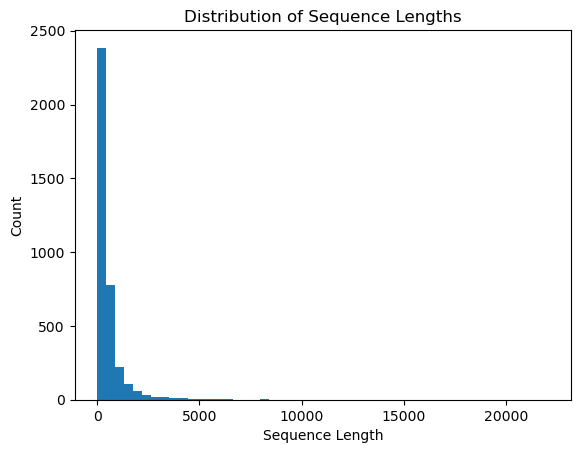

In [18]:
import matplotlib.pyplot as plt
import numpy as np

seq_lengths = [len(seq) for seq in X_sequences]
plt.hist(seq_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths")
plt.show()

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.5347 - loss: 1.3075 - val_accuracy: 0.5258 - val_loss: 1.2424 - learning_rate: 0.0010
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5373 - loss: 1.2371 - val_accuracy: 0.5462 - val_loss: 1.1412 - learning_rate: 0.0010
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5539 - loss: 1.1883 - val_accuracy: 0.5095 - val_loss: 1.2012 - learning_rate: 0.0010
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5504 - loss: 1.1887 - val_accuracy: 0.4293 - val_loss: 1.1479 - learning_rate: 0.0010
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.5331 - loss: 1.1157 - val_accuracy: 0.5503 - val_loss: 1.1239 - learning_rate: 0.0010
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.5477 - loss: 1.1032 - val_accuracy: 0.5476 - val_loss: 1.0873 - learning_rate: 0.0010
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.5515 - loss: 1.0663 - val_acc